# Exercise - AEs

Use the $\texttt{ECG5000}$ dataset$^1$ to perform autoencoding and anomaly detection of ECGs (electrocardiogram - records the electrical signals in the heart). Specifically, split the data into normal and anomalous data as well as a train and test set. 

1. Use a linear and a nonlinear autoencoder to perform reconstructions of the **normal** ECGs. Measure performance both by MSE and MAE. Which model is best on the respective measures (measured on the test data, having used the train data to train the models)? The bottleneck layer should contain 8 neurons.
1. Use one or both of the models from above to perform anomaly detection (you decide which metric, i.e. MSE or MAE, to use for this purpose). That is, find the losses on the training data, and then decide on a threshold above which you classify data as anomolous.
1. Use a supervised model to perform anomaly detection (i.e. use both the normal and anomolous data for training). Is this model better than the approach above? Is this still the case if you restrict the number of anomalies in the training data to a small number (such as 10)?

$^1$http://www.timeseriesclassification.com/description.php?Dataset=ECG5000.

**Hint**: Consider looking at https://www.tensorflow.org/tutorials/generative/autoencoder, as they go through some of the same steps.

**See slides for more details!**

# Setup

This is simply some code to prepare the data. Mostly similar to https://www.tensorflow.org/tutorials/generative/autoencoder.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
print(dataframe.head())
raw_data = dataframe.values
raw_data.shape

        0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.2577

(4998, 141)

In [2]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

In [3]:
scaler = StandardScaler()
scaler.fit(train_data)

x_train = scaler.transform(train_data)
x_test = scaler.transform(test_data)

In [4]:
x_train_normal = x_train[train_labels == 1]
x_train_anomalous = x_train[train_labels == 0]

x_test_normal = x_test[test_labels == 1]
x_test_anomalous = x_test[test_labels == 0]

In [5]:
print(x_train_normal.shape, x_train_anomalous.shape, x_test_normal.shape, x_test_anomalous.shape, train_labels.shape, test_labels.shape)

(2328, 140) (1670, 140) (591, 140) (409, 140) (3998,) (1000,)


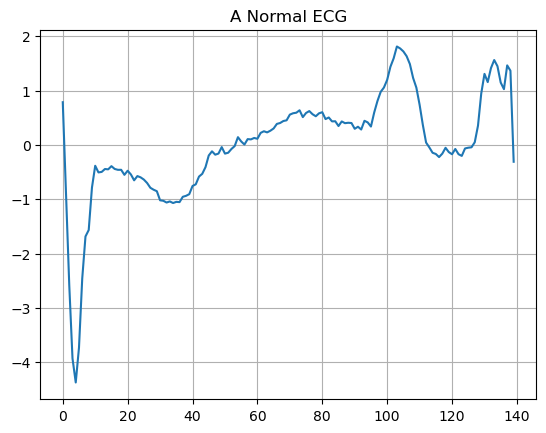

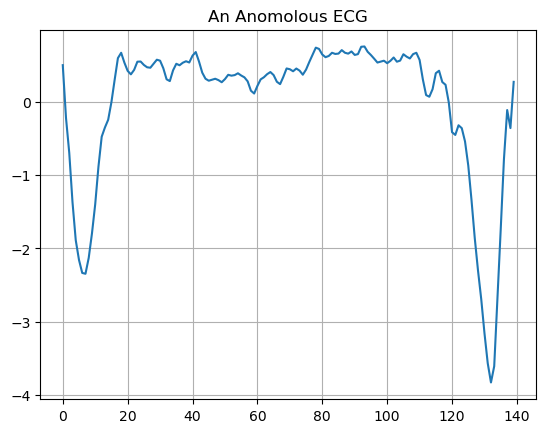

In [6]:
plt.grid()
plt.plot(train_data[train_labels == 1][0])
plt.title("A Normal ECG")
plt.show()

plt.grid()
plt.plot(train_data[train_labels == 0][0])
plt.title("An Anomolous ECG")
plt.show()

# Exercise 1

Use a linear and a nonlinear autoencoder to perform reconstructions of the **normal** ECGs. Measure performance both by MSE and MAE. Which model is best on the respective measures (measured on the test data, having used the train data to train the models)? The bottleneck layer should contain 8 neurons.

Let us define the linear autoencoder below.

In [7]:
encoder_linear = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=(140,)),
], name='encoder')

decoder_linear = tf.keras.models.Sequential([
    tf.keras.layers.Dense(140, input_shape=(8,)),
], name='decoder')

autoencoder_linear = tf.keras.models.Sequential([
    encoder_linear, decoder_linear,
], name='autoencoder')

autoencoder_linear.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [8]:
encoder_linear.summary()
print('\n')
decoder_linear.summary()
print('\n')
autoencoder_linear.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 1128      
                                                                 
Total params: 1,128
Trainable params: 1,128
Non-trainable params: 0
_________________________________________________________________


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 140)               1260      
                                                                 
Total params: 1,260
Trainable params: 1,260
Non-trainable params: 0
_________________________________________________________________


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Seq

Now for the nonlinear autoencoder.

In [9]:
encoder_nonlinear = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape=(140,), activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
], name='encoder')

decoder_nonlinear = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=(8,), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(140),
], name='decoder')

autoencoder_nonlinear = tf.keras.models.Sequential([
    encoder_nonlinear, decoder_nonlinear,
], name='autoencoder')

autoencoder_nonlinear.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [10]:
encoder_nonlinear.summary()
print('\n')
decoder_nonlinear.summary()
print('\n')
autoencoder_nonlinear.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                4512      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
Total params: 5,176
Trainable params: 5,176
Non-trainable params: 0
_________________________________________________________________


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                144       
                                                                 
 dense_6 (Dense)             (None, 32

Let us train them.

In [11]:
hist_linear = autoencoder_linear.fit(
    x=x_train_normal, y=x_train_normal,
    validation_data=(x_test_normal, x_test_normal),
    epochs=20,
)

hist_nonlinear = autoencoder_nonlinear.fit(
    x=x_train_normal, y=x_train_normal,
    validation_data=(x_test_normal, x_test_normal),
    epochs=20,
)

Epoch 1/20
73/73 [==============================] - 2s 9ms/step - loss: 0.7413 - mae: 0.6510 - val_loss: 0.5237 - val_mae: 0.5381
Epoch 2/20
73/73 [==============================] - 0s 7ms/step - loss: 0.3845 - mae: 0.4420 - val_loss: 0.2837 - val_mae: 0.3802
Epoch 3/20
73/73 [==============================] - 1s 8ms/step - loss: 0.2426 - mae: 0.3414 - val_loss: 0.1984 - val_mae: 0.3130
Epoch 4/20
73/73 [==============================] - 1s 8ms/step - loss: 0.1841 - mae: 0.2940 - val_loss: 0.1643 - val_mae: 0.2818
Epoch 5/20
73/73 [==============================] - 1s 9ms/step - loss: 0.1609 - mae: 0.2732 - val_loss: 0.1498 - val_mae: 0.2678
Epoch 6/20
73/73 [==============================] - 1s 9ms/step - loss: 0.1479 - mae: 0.2611 - val_loss: 0.1393 - val_mae: 0.2572
Epoch 7/20
73/73 [==============================] - 1s 8ms/step - loss: 0.1383 - mae: 0.2518 - val_loss: 0.1316 - val_mae: 0.2489
Epoch 8/20
73/73 [==============================] - 1s 7ms/step - loss: 0.1312 - mae: 0.24

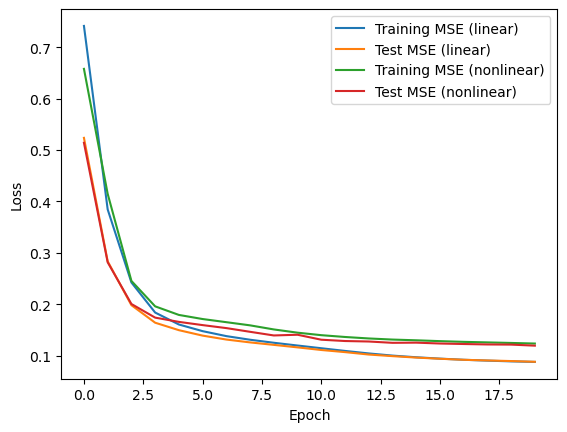

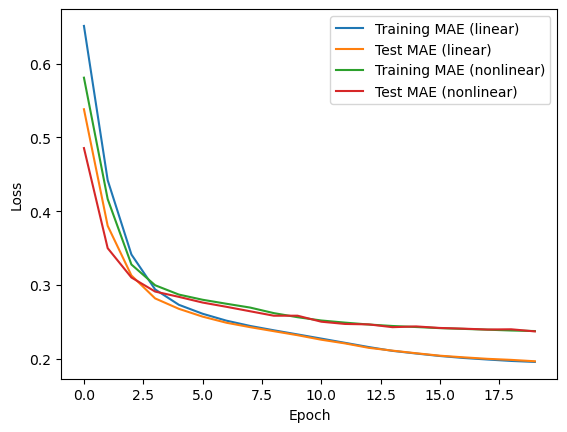

In [12]:
plt.plot(hist_linear.history["loss"], label="Training MSE (linear)")
plt.plot(hist_linear.history["val_loss"], label="Test MSE (linear)")
plt.plot(hist_nonlinear.history["loss"], label="Training MSE (nonlinear)")
plt.plot(hist_nonlinear.history["val_loss"], label="Test MSE (nonlinear)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(hist_linear.history["mae"], label="Training MAE (linear)")
plt.plot(hist_linear.history["val_mae"], label="Test MAE (linear)")
plt.plot(hist_nonlinear.history["mae"], label="Training MAE (nonlinear)")
plt.plot(hist_nonlinear.history["val_mae"], label="Test MAE (nonlinear)")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Exercise 2

Use one or both of the models from above to perform anomaly detection (you decide which metric, i.e. MSE or MAE, to use for this purpose). That is, find the losses on the training data, and then decide on a threshold above which you classify data as anomolous.

Let us find the non-anomaly training and test reconstructions losses for each network.

In [13]:
x_train_normal_reconstructed_linear = autoencoder_linear.predict(x_train_normal)
x_train_normal_reconstructed_nonlinear = autoencoder_nonlinear.predict(x_train_normal)

mse_x_train_normal_linear = tf.keras.losses.mse(x_train_normal_reconstructed_linear, x_train_normal)
mae_x_train_normal_linear = tf.keras.losses.mae(x_train_normal_reconstructed_linear, x_train_normal)
mse_x_train_normal_nonlinear = tf.keras.losses.mse(x_train_normal_reconstructed_nonlinear, x_train_normal)
mae_x_train_normal_nonlinear = tf.keras.losses.mae(x_train_normal_reconstructed_nonlinear, x_train_normal)

73/73 [==============================] - 0s 3ms/step


In [14]:
x_test_normal_reconstructed_linear = autoencoder_linear.predict(x_test_normal)
x_test_normal_reconstructed_nonlinear = autoencoder_nonlinear.predict(x_test_normal)

mse_x_test_normal_linear = tf.keras.losses.mse(x_test_normal_reconstructed_linear, x_test_normal)
mae_x_test_normal_linear = tf.keras.losses.mae(x_test_normal_reconstructed_linear, x_test_normal)
mse_x_test_normal_nonlinear = tf.keras.losses.mse(x_test_normal_reconstructed_nonlinear, x_test_normal)
mae_x_test_normal_nonlinear = tf.keras.losses.mae(x_test_normal_reconstructed_nonlinear, x_test_normal)

19/19 [==============================] - 0s 3ms/step


Now, let us find all the non-anomaly (**note**: here we can use train *and* test as the test set here, as we never actually used the training data for anything).

In [15]:
x_anomalous = np.concatenate([x_train_anomalous, x_test_anomalous])

In [16]:
x_anomalous_reconstructed_linear = autoencoder_linear.predict(x_anomalous)
x_anomalous_reconstructed_nonlinear = autoencoder_nonlinear.predict(x_anomalous)

mse_x_anomalous_linear = tf.keras.losses.mse(x_anomalous_reconstructed_linear, x_anomalous)
mae_x_anomalous_linear = tf.keras.losses.mae(x_anomalous_reconstructed_linear, x_anomalous)
mse_x_anomalous_nonlinear = tf.keras.losses.mse(x_anomalous_reconstructed_nonlinear, x_anomalous)
mae_x_anomalous_nonlinear = tf.keras.losses.mae(x_anomalous_reconstructed_nonlinear, x_anomalous)

65/65 [==============================] - 0s 3ms/step


Let us plot histograms of the values. Very clear to see that the normal and anomalous losses are quite different, but they are partly overlapping!

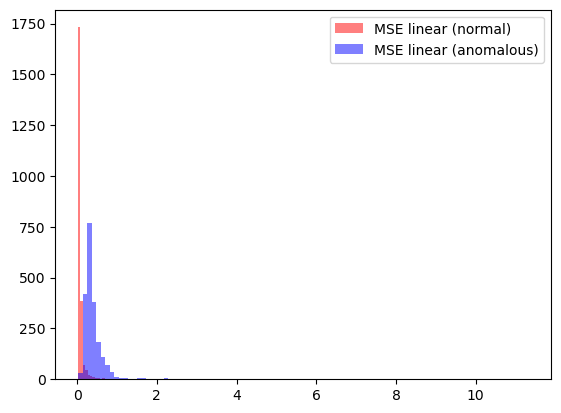

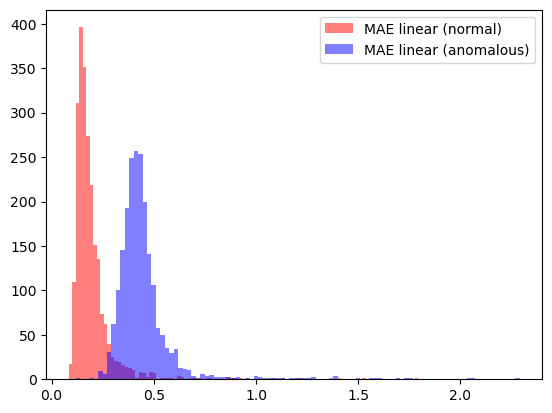

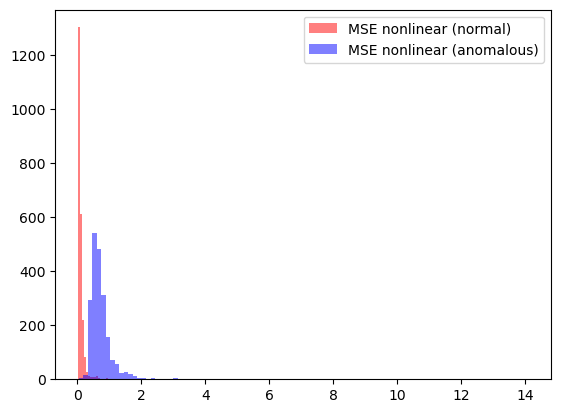

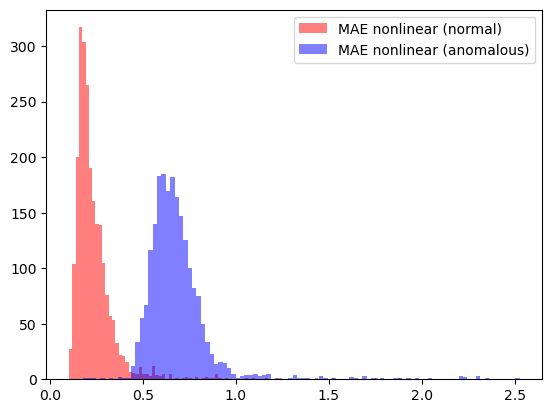

In [17]:
plt.hist(mse_x_train_normal_linear, bins=100, label='MSE linear (normal)', fc=(1, 0, 0, 0.5));
plt.hist(mse_x_anomalous_linear, bins=100, label='MSE linear (anomalous)', fc=(0, 0, 1, 0.5));
plt.legend()
plt.show()

plt.hist(mae_x_train_normal_linear, bins=100, label='MAE linear (normal)', fc=(1, 0, 0, 0.5));
plt.hist(mae_x_anomalous_linear, bins=100, label='MAE linear (anomalous)', fc=(0, 0, 1, 0.5));
plt.legend()
plt.show()

plt.hist(mse_x_train_normal_nonlinear, bins=100, label='MSE nonlinear (normal)', fc=(1, 0, 0, 0.5));
plt.hist(mse_x_anomalous_nonlinear, bins=100, label='MSE nonlinear (anomalous)', fc=(0, 0, 1, 0.5));
plt.legend()
plt.show()

plt.hist(mae_x_train_normal_nonlinear, bins=100, label='MAE nonlinear (normal)', fc=(1, 0, 0, 0.5));
plt.hist(mae_x_anomalous_nonlinear, bins=100, label='MAE nonlinear (anomalous)', fc=(0, 0, 1, 0.5));
plt.legend()
plt.show()

We now need to determine a "cutoff" or "threshold" value, above which we classify an observation as an outlier.

If we were very strict, we weren't really allowed to look at the histograms above (as these include test observations), but we aren't actually going to use them, so it is no matter.

Instead, let just simply try some different threshold values and see how we trade between type I versus type II erros as we do this.

Specifically, we will use the training non anomalous data, going from the 75% quantile to the 99% quantile.

In [18]:
thresholds_mse_linear = np.linspace(np.quantile(mse_x_train_normal_linear, 0.75), np.quantile(mse_x_train_normal_linear, 0.99), 25)
thresholds_mae_linear = np.linspace(np.quantile(mae_x_train_normal_linear, 0.75), np.quantile(mae_x_train_normal_linear, 0.99), 25)
thresholds_mse_nonlinear = np.linspace(np.quantile(mse_x_train_normal_nonlinear, 0.75), np.quantile(mse_x_train_normal_nonlinear, 0.99), 25)
thresholds_mae_nonlinear = np.linspace(np.quantile(mae_x_train_normal_nonlinear, 0.75), np.quantile(mae_x_train_normal_nonlinear, 0.99), 25)

In [19]:
thresholds = zip(thresholds_mse_linear, thresholds_mae_linear, thresholds_mse_nonlinear, thresholds_mae_nonlinear)

In [20]:
reconstructions_linear = autoencoder_linear.predict(x_test)
reconstructions_nonlinear = autoencoder_nonlinear.predict(x_test)

32/32 [==============================] - 0s 2ms/step


In [21]:
mse_reconstructions_linear = tf.keras.losses.mse(reconstructions_linear, x_test)
mae_reconstructions_linear = tf.keras.losses.mae(reconstructions_linear, x_test)
mse_reconstructions_nonlinear = tf.keras.losses.mse(reconstructions_nonlinear, x_test)
mae_reconstructions_nonlinear = tf.keras.losses.mae(reconstructions_nonlinear, x_test)

In [22]:
def get_scores(losses, y, threshold):
    yhat = tf.math.less(losses, threshold) #Returns the truth value of (losses < threshold) element-wise.
    
    acc = accuracy_score(y, yhat)
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    
    return acc, precision, recall

In [23]:
results_linear_mse = []
results_linear_mae = []
results_nonlinear_mse = []
results_nonlinear_mae = []

for th_mse_l, th_mae_l, th_mse_nl, th_mae_nl in thresholds:
    acc_l_mse, precision_l_mse, recall_l_mse = get_scores(mse_reconstructions_linear, test_labels, th_mse_l)
    acc_l_mae, precision_l_mae, recall_l_mae = get_scores(mae_reconstructions_linear, test_labels, th_mae_l)
    acc_nl_mse, precision_nl_mse, recall_nl_mse = get_scores(mse_reconstructions_nonlinear, test_labels, th_mse_nl)
    acc_nl_mae, precision_nl_mae, recall_nl_mae = get_scores(mae_reconstructions_nonlinear, test_labels, th_mae_nl)

    results_linear_mse.append((acc_l_mse, precision_l_mse, recall_l_mse))
    results_linear_mae.append((acc_l_mae, precision_l_mae, recall_l_mae))
    results_nonlinear_mse.append((acc_nl_mse, precision_nl_mse, recall_nl_mse))
    results_nonlinear_mae.append((acc_nl_mae, precision_nl_mae, recall_nl_mae))

In [24]:
results_linear_mse = pd.DataFrame(results_linear_mse, columns=['Accuracy', 'Precision', 'Recall'])
results_linear_mae = pd.DataFrame(results_linear_mae, columns=['Accuracy', 'Precision', 'Recall'])
results_nonlinear_mse = pd.DataFrame(results_nonlinear_mse, columns=['Accuracy', 'Precision', 'Recall'])
results_nonlinear_mae = pd.DataFrame(results_nonlinear_mae, columns=['Accuracy', 'Precision', 'Recall'])

Let us now look at the precision/recall trade-offs of the models.

Reminder: 
- Precision:  fraction of persons with a positive test result who do have the disease. Calculated as TP / (TP + FP).
- Recall: fraction of persons with disease who get a positive test result. Calculated as TP / (TP + FN).

This is called a reciever operating characteristics curve (although those typically reverse the x-axis).

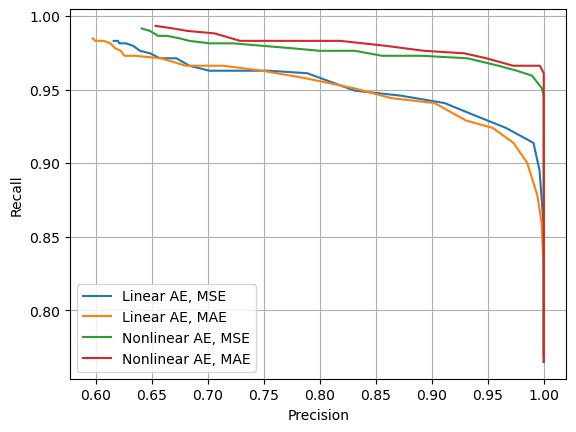

In [25]:
plt.plot(results_linear_mse['Precision'], results_linear_mse['Recall'], label='Linear AE, MSE')
plt.plot(results_linear_mae['Precision'], results_linear_mae['Recall'], label='Linear AE, MAE')
plt.plot(results_nonlinear_mse['Precision'], results_nonlinear_mse['Recall'], label='Nonlinear AE, MSE')
plt.plot(results_nonlinear_mae['Precision'], results_nonlinear_mae['Recall'], label='Nonlinear AE, MAE')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()

It seems the best model is the nonlinear AE, using MAE. It achieves also very high accuracy (we can detect about 97% of the anomalies with a precision of 100%)

In [26]:
results_nonlinear_mae

,Accuracy,Precision,Recall
0,0.861,1.000000,0.764805
1,0.885,1.000000,0.805415
2,0.908,1.000000,0.844332
3,0.927,1.000000,0.876481
4,0.939,1.000000,0.896785
5,0.951,1.000000,0.917090
6,0.964,1.000000,0.939086
7,0.967,1.000000,0.944162
8,0.971,1.000000,0.950931
9,0.977,1.000000,0.961083


# Exercise 3

Use a supervised model to perform anomaly detection (i.e. use both the normal and anomolous data for training). Is this model better than the approach above? Is this still the case if you restrict the number of anomalies in the training data to a small number (such as 10)?

In [27]:
supervised_anomaly_detecter = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(140,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

supervised_anomaly_detecter.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

supervised_anomaly_detecter.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                9024      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
Total params: 11,666
Trainable params: 11,666
Non-trainable params: 0
_________________________________________________________________


In [28]:
hist_supervised = supervised_anomaly_detecter.fit(x_train, train_labels, validation_data=(x_test, test_labels), epochs=20)

Epoch 1/20
125/125 [==============================] - 2s 10ms/step - loss: 0.0913 - accuracy: 0.9747 - val_loss: 0.0155 - val_accuracy: 0.9970
Epoch 2/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0340 - accuracy: 0.9900 - val_loss: 0.0176 - val_accuracy: 0.9950
Epoch 3/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0238 - accuracy: 0.9935 - val_loss: 0.0131 - val_accuracy: 0.9950
Epoch 4/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0203 - accuracy: 0.9937 - val_loss: 0.0104 - val_accuracy: 0.9960
Epoch 5/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0211 - accuracy: 0.9940 - val_loss: 0.0087 - val_accuracy: 0.9980
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 0.0160 - accuracy: 0.9957 - val_loss: 0.0059 - val_accuracy: 0.9990
Epoch 7/20
125/125 [==============================] - 1s 9ms/step - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.0106 - val_accuracy: 0.9970
Epoch

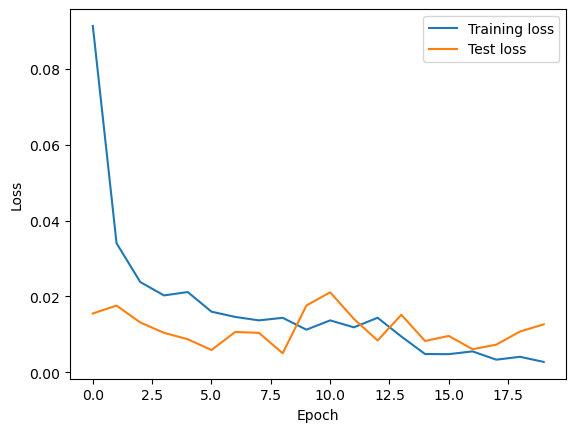

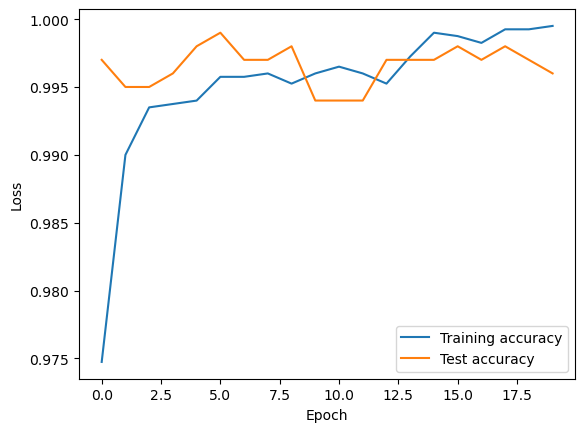

In [29]:
plt.plot(hist_supervised.history["loss"], label="Training loss")
plt.plot(hist_supervised.history["val_loss"], label="Test loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(hist_supervised.history["accuracy"], label="Training accuracy")
plt.plot(hist_supervised.history["val_accuracy"], label="Test accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

It performs quite good. But imagine if we had VERY few training anomalies! Let us simulate that.

We will use the same model, but lower number of anomalies in the training data.

We will use the same test data.

In [30]:
supervised_anomaly_detecter_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(140,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

supervised_anomaly_detecter_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

supervised_anomaly_detecter_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                9024      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 2)                 34        
                                                                 
Total params: 11,666
Trainable params: 11,666
Non-trainable params: 0
_________________________________________________________________


In [31]:
hist_supervised_2 = supervised_anomaly_detecter_2.fit(
    x=np.concatenate([x_train_normal, x_train_anomalous[:10]]), # 10 examples
    y=np.concatenate([train_labels[train_labels == 1], train_labels[train_labels == 0][:10]]), 
    validation_data=(x_test, test_labels), epochs=20)

Epoch 1/20
74/74 [==============================] - 1s 11ms/step - loss: 0.0548 - accuracy: 0.9850 - val_loss: 0.5023 - val_accuracy: 0.7080
Epoch 2/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.4049 - val_accuracy: 0.8980
Epoch 3/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.3193 - val_accuracy: 0.9260
Epoch 4/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2723 - val_accuracy: 0.9500
Epoch 5/20
74/74 [==============================] - 1s 9ms/step - loss: 6.7410e-04 - accuracy: 1.0000 - val_loss: 0.2469 - val_accuracy: 0.9570
Epoch 6/20
74/74 [==============================] - 1s 10ms/step - loss: 3.1890e-04 - accuracy: 1.0000 - val_loss: 0.2480 - val_accuracy: 0.9580
Epoch 7/20
74/74 [==============================] - 1s 9ms/step - loss: 1.8658e-04 - accuracy: 1.0000 - val_loss: 0.2546 - val_accuracy: 0.9550
Epoch 

Now performance is worse. 

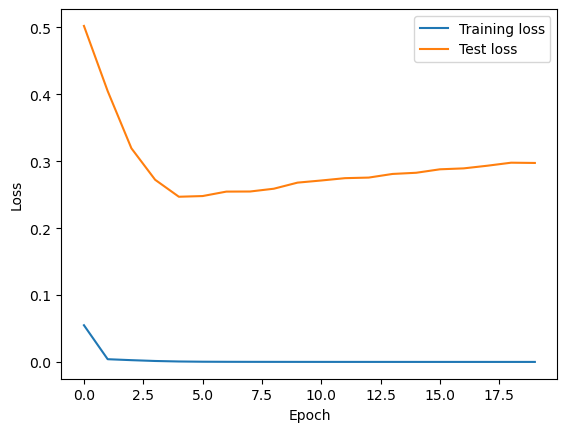

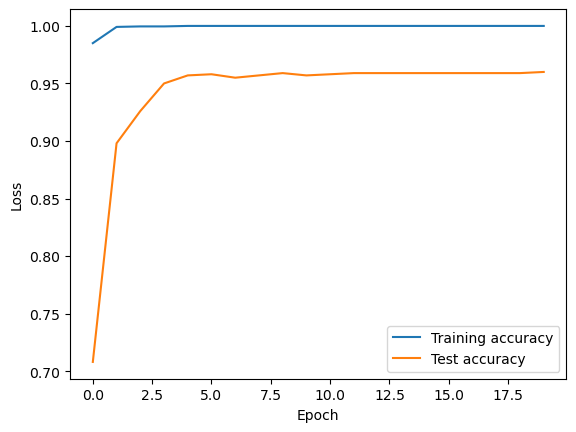

In [32]:
plt.plot(hist_supervised_2.history["loss"], label="Training loss")
plt.plot(hist_supervised_2.history["val_loss"], label="Test loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(hist_supervised_2.history["accuracy"], label="Training accuracy")
plt.plot(hist_supervised_2.history["val_accuracy"], label="Test accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()